In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Project root (one level up from notebooks/)
project_root = Path().resolve().parent
data_dir = project_root / 'data'
outputs  = project_root / 'outputs'

# Load the final labeled data
checked  = outputs / 'vivollo_final_checked.csv'
fallback = outputs / 'vivollo_final.csv'
if checked.exists():
    df = pd.read_csv(checked, parse_dates=['created_at'])
elif fallback.exists():
    df = pd.read_csv(fallback, parse_dates=['created_at'])
else:
    raise FileNotFoundError("Neither vivollo_final_checked.csv nor vivollo_final.csv found in outputs/")

# Load splits
train_path = data_dir / 'train.csv'
val_path   = data_dir / 'val.csv'
test_path  = data_dir / 'test.csv'

train = pd.read_csv(train_path) if train_path.exists() else None
val   = pd.read_csv(val_path)   if val_path.exists()   else None
test  = pd.read_csv(test_path)  if test_path.exists()  else None

print(f"Loaded df ({len(df)} rows), train={len(train) if train is not None else 0}, val={len(val) if val is not None else 0}")


Loaded df (10344 rows), train=2402, val=600


## 1. Kategori Dağılımı


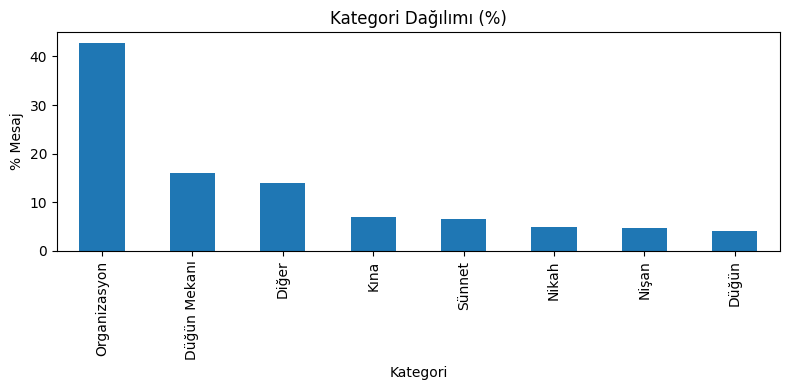

In [3]:
category_dist = df['kategori'].value_counts(normalize=True).mul(100).round(2)

plt.figure(figsize=(8,4))
category_dist.plot(kind='bar')
plt.title('Kategori Dağılımı (%)')
plt.ylabel('% Mesaj')
plt.xlabel('Kategori')
plt.tight_layout()
plt.show()


## 2. Sentiment & Intent Dağılımları


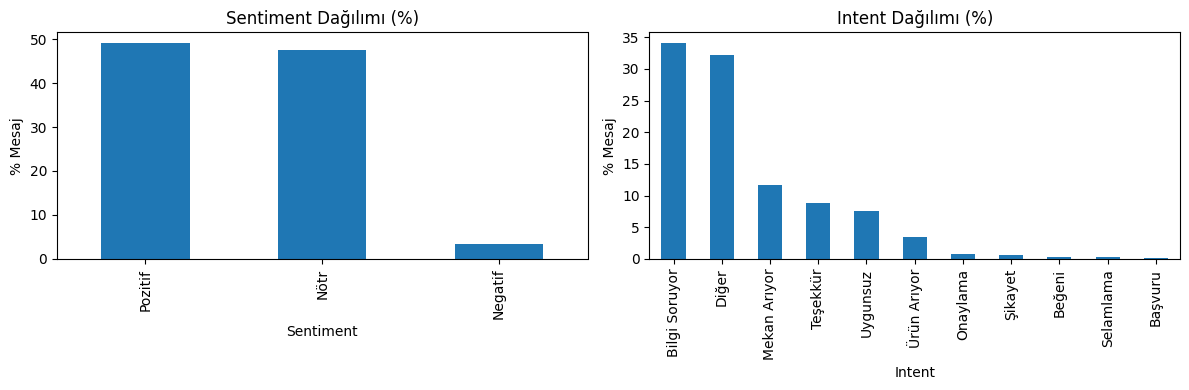

In [5]:
sentiment_dist = df['sentiment'].value_counts(normalize=True).mul(100).round(2)
intent_dist    = df['intent'].value_counts(normalize=True).mul(100).round(2)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sentiment_dist.plot(kind='bar', ax=axes[0])
axes[0].set_title('Sentiment Dağılımı (%)')
axes[0].set_ylabel('% Mesaj')
axes[0].set_xlabel('Sentiment')

intent_dist.plot(kind='bar', ax=axes[1])
axes[1].set_title('Intent Dağılımı (%)')
axes[1].set_ylabel('% Mesaj')
axes[1].set_xlabel('Intent')

plt.tight_layout()
plt.show()


## 3. Aylık Yanıtlanma Oranı (%)


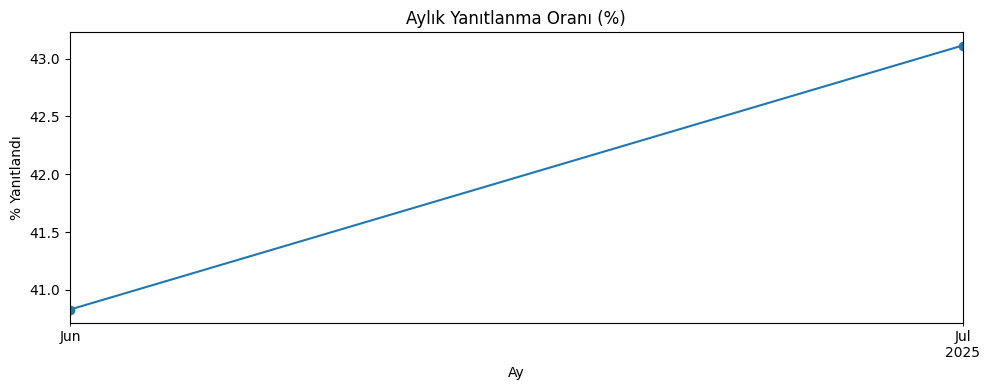

In [7]:
df['month'] = df['created_at'].dt.to_period('M')
trend = df.groupby('month')['yanitlandi_mi'].apply(lambda s: (s=='Evet').mean()*100)

plt.figure(figsize=(10,4))
trend.sort_index().plot(marker='o')
plt.title('Aylık Yanıtlanma Oranı (%)')
plt.ylabel('% Yanıtlandı')
plt.xlabel('Ay')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Hata Simülasyonu


## Neden Simülasyon Yaptık?

Canlı sohbette karşılaşılan “taslak doldurma”, “model belirsizliği” ve “API hatası” gibi farklı hata kaynaklarının, gerçek dünyada ne ölçüde kullanıcı deneyimini zedeleyebileceğini kestirmek için simülasyon yaptık.  
- **Slot‑filling** kuralı çok katı olduğunda, eksik veriler yüzünden öneri yapılamayan vakaların oranı yükseliyor.  
- **Model fallback** senaryosu (düşük güvenli tahminlerde insan müdahalesi) sistemin yanıt oranını nasıl etkilediğini gösteriyor.  
- **API retry** mekanizması, üçüncü‑taraf servis hatalarını ne kadar azaltabileceğimizi ölçmemizi sağlıyor.  

Bu simülasyonlar, hangi geliştirme adımlarının (kural eşiği ayarı, fallback stratejisi, retry mekanizması) en yüksek faydayı getireceğini önceliklendirmemize yardımcı oluyor.


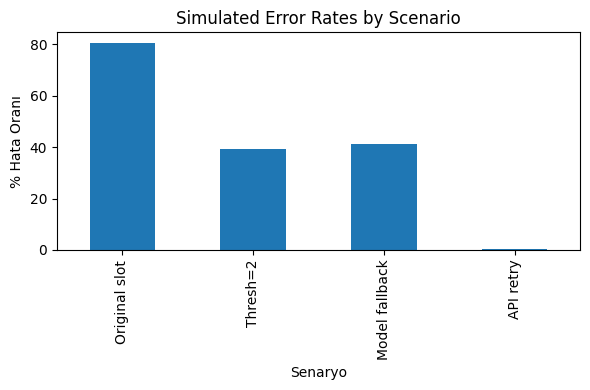

In [18]:
# %% 
# Simülasyon Sonuçlarının Görselleştirilmesi
sim = pd.read_csv(project_root / 'outputs' / 'simulation_result.csv', index_col='Scenario')

plt.figure(figsize=(6,4))
sim['Error rate (%)'].plot(kind='bar')
plt.title('Simulated Error Rates by Scenario')
plt.ylabel('% Hata Oranı')
plt.xlabel('Senaryo')
plt.tight_layout()
plt.show()


### Simülasyon Sonuçları ve Yorum

- **Orijinal slot‑filling** senaryosunda hata oranı %80.6; çok katı bekleme kuralı yüzünden yanıt verilemeyen vakalar yüksek.
- **Eşiği 2 slot’a düşürünce** hata oranı %39.2’ye indi; böylece erken öneri fırsatları artıyor.
- **Model fallback** senaryosu da benzer bir düşüş sağladı (%41.4).
- **API retry** mekanizması ise dış sistem hatalarını neredeyse tamamen (%0.36) ortadan kaldırıyor.

Bu sonuçlar, öneri kuralını gevşetmenin ve servis çağrılarını retry mekanizması eklemenin en büyük etkiyi sağladığını gösteriyor.

